<a href="https://colab.research.google.com/github/4232177191/project1/blob/main/neumeric_to_cattegoric_deibet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

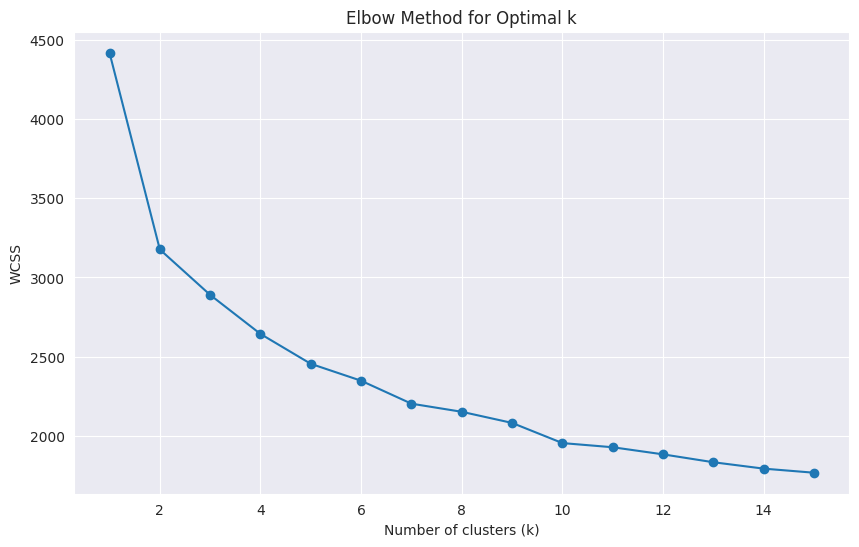

Optimal number of clusters: 9
Results for Percentage: 0.11
    Actual Target  Predicted Target (Overall)  Difference (Overall)  \
0            37.0                   95.008772             58.008772   
1            55.0                   95.008772             40.008772   
2           202.0                   95.008772           -106.991228   
3           252.0                   95.008772           -156.991228   
4            42.0                   95.008772             53.008772   
5            77.0                   95.008772             18.008772   
6           101.0                   95.008772             -5.991228   
7            97.0                   95.008772             -1.991228   
8           200.0                   95.008772           -104.991228   
9           220.0                   95.008772           -124.991228   
10          140.0                   95.008772            -44.991228   
11          151.0                   95.008772            -55.991228   
12           83.0 

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode
from seaborn import set_style
set_style('darkgrid')

# بارگذاری دیتا ست دیابت
diabet = load_diabetes()
data = pd.DataFrame(diabet.data, columns=diabet.feature_names)
data["target"] = diabet.target

# پیش‌پردازش داده‌ها (استانداردسازی)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-1])  # تمامی ستون‌ها به جز ستون نتیجه

# استفاده از K-Means برای تعیین تعداد کلاستر
wcss = []  # مجموع مربعات درون کلاسترها
max_k = 15  # حداکثر تعداد کلاسترها

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)  # ذخیره مجموع مربعات درون کلاسترها

# رسم نمودار روش آرنج
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

plt.show()

# محاسبه نقطه عطف (Elbow) به صورت خودکار
diff = np.diff(wcss)
diff2 = np.diff(diff)

# پیدا کردن نقطه عطف
optimal_k = np.argmin(diff2) + 2  # +2 برای تنظیم ایندکس به تعداد کلاستر

# چاپ تعداد کلاستر بهینه
print(f"Optimal number of clusters: {optimal_k}")

# اجرای K-Means با تعداد کلاسترهای بهینه
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(data_scaled)

# اضافه کردن برچسب کلاستر به داده‌ها
data['Cluster'] = kmeans.labels_

# ایجاد مجموعه تست
percentages = np.arange(0.11, 0.16, 0.01)
results = []

# برای هر درصد، پیش‌بینی انجام دهیم
for p in percentages:
    # دریافت تعداد نمونه‌های برابر با درصد
    test_size = int(len(data) * p)
    test_data = data.sample(n=test_size, replace=False)  # انتخاب پراکنده و تصادفی

    # ایجاد مجموعه آموزشی
    train_data = data.drop(test_data.index)

    y_train = train_data['Cluster']  # برچسب‌های آموزشی
    k_neighbors = int(np.sqrt(len(y_train)))  # تعیین تعداد همسایه‌ها

    # پیش‌بینی با کلاسمتر ویژگی محور
    predicted_classes_list_feature_based = []
    target_values_per_feature = []

    # اجرای KNN برای هر ویژگی
    for i in range(data.shape[1] - 2):  # به جز ستون‌های target و Cluster
        X_train_feature = train_data.iloc[:, [i]].values  # فقط یک فیچر برای آموزش
        X_test_feature = test_data.iloc[:, [i]].values  # فقط یک فیچر برای تست

        knn = KNeighborsClassifier(n_neighbors=k_neighbors)  # استفاده از k_neighbors
        knn.fit(X_train_feature, y_train)  # آموزش

        # پیش‌بینی
        predicted_classes = knn.predict(X_test_feature)  # داده آزمایشی
        predicted_classes_list_feature_based.append(predicted_classes)  # ذخیره پیش‌بینی

        # ذخیره مقدار تارگت همسایه‌ها
        neighbors_indices = knn.kneighbors(X_test_feature, return_distance=False)
        for index in neighbors_indices:
            valid_neighbors = train_data.iloc[index.flatten()]
            tar_values = valid_neighbors[valid_neighbors['Cluster'] == predicted_classes[0]]['target']
            target_values_per_feature.extend(tar_values)  # ذخیره مقادیر تارگت همسایه‌ها

    # تبدیل لیست پیش‌بینی‌ها به آرایه
    predicted_classes_array_feature_based = np.array(predicted_classes_list_feature_based).T
    final_predictions_feature_based = mode(predicted_classes_array_feature_based, axis=1)[0].flatten()

    # محاسبه میانگین تارگت عددی برای روش ویژگی‌محور
    overall_mean_numeric_target_feature_based = np.mean(target_values_per_feature) if target_values_per_feature else 0

    # KNN کلی
    knn_overall = KNeighborsClassifier(n_neighbors=k_neighbors)  # استفاده از k_neighbors
    knn_overall.fit(data_scaled, data['Cluster'])  # آموزش روی تمامی ویژگی‌ها
    predicted_classes_overall = knn_overall.predict(scaler.transform(test_data.iloc[:, :-2]))  # پیش‌بینی

    # ذخیره مقدار تارگت همسایه‌ها برای KNN کلی
    overall_target_values = []
    overall_neighbors_indices = knn_overall.kneighbors(scaler.transform(test_data.iloc[:, :-2]), return_distance=False)

    for index in overall_neighbors_indices:
        valid_neighbors = data.iloc[index.flatten()]
        tar_values = valid_neighbors[valid_neighbors['Cluster'] == predicted_classes_overall[0]]['target']
        overall_target_values.extend(tar_values)  # ذخیره مقادیر تارگت همسایه‌ها

    # محاسبه میانگین تارگت عددی برای KNN کلی
    overall_mean_numeric_target_overall = np.mean(overall_target_values) if overall_target_values else 0

    # ساخت یک DataFrame برای ذخیره نتایج
    result_df = pd.DataFrame({
        "Actual Target": test_data['target'].values,
        "Predicted Target (Overall)": overall_mean_numeric_target_overall,
        "Difference (Overall)": overall_mean_numeric_target_overall - test_data['target'].values,
        "Predicted Target (Feature-based)": overall_mean_numeric_target_feature_based,
        "Difference (Feature-based)": overall_mean_numeric_target_feature_based - test_data['target'].values
    })

    results.append(result_df)

# نمایش نتایج برای همه درصدها
for idx, res in enumerate(results):
    print(f"Results for Percentage: {percentages[idx]:.2f}")
    print(res)
    print("\n")

Optimal number of clusters: 8


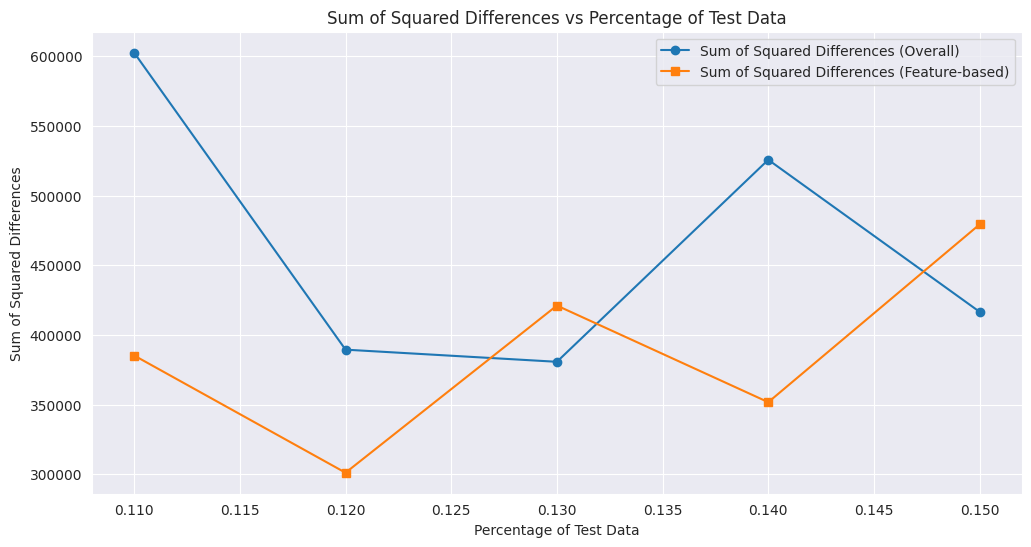

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode

# بارگذاری دیتا ست دیابت
diabet = load_diabetes()
data = pd.DataFrame(diabet.data, columns=diabet.feature_names)
data["target"] = diabet.target

# پیش‌پردازش داده‌ها (استانداردسازی)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-1])  # تمامی ستون‌ها به جز ستون نتیجه

# استفاده از K-Means برای تعیین تعداد کلاستر
wcss = []  # مجموع مربعات درون کلاسترها
max_k = 15  # حداکثر تعداد کلاسترها

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)  # ذخیره مجموع مربعات درون کلاسترها

# محاسبه نقطه عطف (Elbow) به صورت خودکار
diff = np.diff(wcss)
diff2 = np.diff(diff)
optimal_k = np.argmin(diff2) + 2  # +2 برای تنظیم ایندکس به تعداد کلاستر
print(f"Optimal number of clusters: {optimal_k}")

# اجرای K-Means با تعداد کلاسترهای بهینه
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(data_scaled)
data['Cluster'] = kmeans.labels_

# ایجاد مجموعه تست
percentages = np.arange(0.11, 0.16, 0.01)
results = []
sum_squared_diffs_overall = []
sum_squared_diffs_feature_based = []

# برای هر درصد، پیش‌بینی انجام دهیم
for p in percentages:
    test_size = int(len(data) * p)
    test_data = data.sample(n=test_size,  replace=False)  # انتخاب پراکنده و تصادفی
    train_data = data.drop(test_data.index)
    y_train = train_data['Cluster']
    k_neighbors = int(np.sqrt(len(y_train)))

    # پیش‌بینی با کلاسمتر ویژگی محور
    predicted_classes_feature_based = []
    target_values_feature_based = []

    for i in range(data.shape[1] - 2):  # به جز ستون‌های target و Cluster
        X_train_feature = train_data.iloc[:, [i]].values
        X_test_feature = test_data.iloc[:, [i]].values

        knn = KNeighborsClassifier(n_neighbors=k_neighbors)
        knn.fit(X_train_feature, y_train)
        predicted_classes = knn.predict(X_test_feature)
        predicted_classes_feature_based.append(predicted_classes)

        # ذخیره مقدار تارگت همسایه‌ها
        neighbors_indices = knn.kneighbors(X_test_feature, return_distance=False)
        for index in neighbors_indices:
            valid_neighbors = train_data.iloc[index.flatten()]
            tar_values = valid_neighbors[valid_neighbors['Cluster'] == predicted_classes[0]]['target']
            target_values_feature_based.extend(tar_values)

    predicted_classes_array_feature_based = np.array(predicted_classes_feature_based).T
    final_predictions_feature_based = mode(predicted_classes_array_feature_based, axis=1)[0].flatten()
    overall_mean_numeric_target_feature_based = np.mean(target_values_feature_based) if target_values_feature_based else 0

    # KNN کلی
    knn_overall = KNeighborsClassifier(n_neighbors=k_neighbors)
    knn_overall.fit(data_scaled, data['Cluster'])
    predicted_classes_overall = knn_overall.predict(scaler.transform(test_data.iloc[:, :-2]))

    # ذخیره مقدار تارگت همسایه‌ها برای KNN کلی
    overall_target_values = []
    overall_neighbors_indices = knn_overall.kneighbors(scaler.transform(test_data.iloc[:, :-2]), return_distance=False)
    for index in overall_neighbors_indices:
        valid_neighbors = data.iloc[index.flatten()]
        tar_values = valid_neighbors[valid_neighbors['Cluster'] == predicted_classes_overall[0]]['target']
        overall_target_values.extend(tar_values)

    overall_mean_numeric_target_overall = np.mean(overall_target_values) if overall_target_values else 0

    # محاسبه مجموع مربعات اختلاف‌ها
    sum_squared_diff_overall = np.sum((test_data['target'].values - overall_mean_numeric_target_overall) ** 2)
    sum_squared_diff_feature_based = np.sum((test_data['target'].values - overall_mean_numeric_target_feature_based) ** 2)

    sum_squared_diffs_overall.append(sum_squared_diff_overall)
    sum_squared_diffs_feature_based.append(sum_squared_diff_feature_based)

# رسم نمودار مجموع مربعات اختلاف‌ها
plt.figure(figsize=(12, 6))
plt.plot(percentages, sum_squared_diffs_overall, marker='o', label='Sum of Squared Differences (Overall)')
plt.plot(percentages, sum_squared_diffs_feature_based, marker='s', label='Sum of Squared Differences (Feature-based)')
plt.title('Sum of Squared Differences vs Percentage of Test Data')
plt.xlabel('Percentage of Test Data')
plt.ylabel('Sum of Squared Differences')
plt.legend()

plt.show()